# TODO
* Agregar el regex para que <number>gb<number>gb se separen
* Testing
* Verificar tipos de respuesta
* Varificar grafos https://github.com/networkx/networkx
* https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

# TESTED
* NGramas -> en realidad no me aportó mas información
* Hacer un arbol y ponerlo como grafo -- visualmente funciona
* El grafo no funciona porque elimina algunos elementos que son de importancia si tomamos por comunidad
* Limpiar todo lo posible

In [3]:
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
from bs4 import BeautifulSoup
from typing import List
import concurrent.futures
from itertools import repeat
from itertools import chain
from nltk.corpus import stopwords

SEARCH_WORD = 'xiaomi'
URL = f'https://listado.mercadolibre.com.ar/{SEARCH_WORD}#D[A:{SEARCH_WORD}]'

MAX_THREADS = 10

import string
import re

stopwords = set(stopwords.words("spanish"))-set(["mi"])

URL_PATTERN = re.compile(r'[^\w\s]')
GB_PATTERN = re.compile(r"(([0-9]*) gb)")
GB_MERGED_PATTERN = re.compile(r"(([0-9]*)gb([0-9]*)gb)")
KEY_PATTERN = re.compile(r'(([^\n\r]*)\s+({}\s[^\n\r]*))'.format(SEARCH_WORD))

COLLECTION_WORDS = ("celular","permuto","vendo","smartphone","izalo","telefono","xiaomi","xioami","xiomi","xiaomo")

def remove_stopwords(sentence):
    return [word for word in sentence if word not in stopwords.words("spanish")]

def preprocess_article(article):
    """normalize texts
    * lowercase
    * strip
    * <number> gb -> <number>gb
    * Send Xiaomi and the rest of the message to the start of the article
    """
    cleaned_article = URL_PATTERN.sub('', article.get_text()).lower().strip()
    cleaned_article = GB_PATTERN.sub(r'\2gb', cleaned_article)
    cleaned_article = GB_MERGED_PATTERN.sub(r'\2gb \3gb', cleaned_article)
    cleaned_article = KEY_PATTERN.sub(r'\3 \2', cleaned_article)
    return cleaned_article

def get_content(name:str, attributes:dict, url:str, limit:int=None):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print(e)
        return None
    except URLError as e:
        print("Server not found") 
        return None
    try:
        bs = BeautifulSoup(html)
        element=bs.find_all(name, attributes, limit=limit)
    except AttributeError as e:
        print(e)
        return None
    return element

def get_links(url:str, limit:int=5):
    page_links = get_content('a', {'class':'andes-pagination__link'}, url, limit)[1:]
    page_links = [link.attrs["href"] for link in page_links]
    return [URL]+page_links

def get_article_titles(urls:List[str]):
    threads = min(MAX_THREADS, len(urls))
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        records = executor.map(get_content, repeat('span'),repeat({'class':'main-title'}),urls)
        #titles = get_content('span',{'class':'main-title'},url) #no thread version  
    return set(map(preprocess_article , chain(*records)))

In [4]:
# Getting all the Xiaomi phones from gsmarena since mi.com doesn't have all the models
gsmarena_url = 'https://www.gsmarena.com/'
product = 'xiaomi-phones-80.php'
def get_xiaomi_links(url:str):
    page_links = get_content('div',{'class':'nav-pages'}, gsmarena_url+product)
    page_links = [gsmarena_url+link.attrs["href"] for link in page_links[0].find_all("a")]
    return page_links
xi_url = [gsmarena_url+product]+get_xiaomi_links(gsmarena_url)
print(xi_url)
def get_xiaomi_models(url:str):
    threads = min(MAX_THREADS, len(url))
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        records = executor.map(get_content, repeat('div'),repeat({'class':'makers'}),url)
    return sorted([model.get_text().lower() for record in records for model in record[0].find_all("span")])
all_xiaomi_models = get_xiaomi_models(xi_url)
all_xiaomi_models

['https://www.gsmarena.com/xiaomi-phones-80.php', 'https://www.gsmarena.com/xiaomi-phones-f-80-0-p2.php', 'https://www.gsmarena.com/xiaomi-phones-f-80-0-p3.php', 'https://www.gsmarena.com/xiaomi-phones-f-80-0-p4.php']


['black shark',
 'black shark 2',
 'black shark 2 pro',
 'black shark 3',
 'black shark 3 pro',
 'black shark 3s',
 'black shark helo',
 'mi 10 5g',
 'mi 10 lite 5g',
 'mi 10 pro 5g',
 'mi 10 youth 5g',
 'mi 1s',
 'mi 2',
 'mi 2a',
 'mi 2s',
 'mi 3',
 'mi 4',
 'mi 4 lte',
 'mi 4c',
 'mi 4i',
 'mi 4s',
 'mi 5',
 'mi 5c',
 'mi 5s',
 'mi 5s plus',
 'mi 6',
 'mi 6 plus',
 'mi 6c',
 'mi 8',
 'mi 8 explorer',
 'mi 8 lite',
 'mi 8 pro',
 'mi 8 se',
 'mi 9',
 'mi 9 explorer',
 'mi 9 lite',
 'mi 9 pro',
 'mi 9 pro 5g',
 'mi 9 se',
 'mi 9t',
 'mi 9t pro',
 'mi 9x',
 'mi a1 (mi 5x)',
 'mi a2 (mi 6x)',
 'mi a2 lite (redmi 6 pro)',
 'mi a3',
 'mi cc9',
 'mi cc9 pro',
 'mi cc9e',
 'mi max',
 'mi max 2',
 'mi max 3',
 'mi max 4',
 'mi max 4 pro',
 'mi mix',
 'mi mix 2',
 'mi mix 2s',
 'mi mix 3',
 'mi mix 3 5g',
 'mi mix alpha',
 'mi note',
 'mi note 10',
 'mi note 10 lite',
 'mi note 10 pro',
 'mi note 2',
 'mi note 3',
 'mi note plus',
 'mi note pro',
 'mi pad 2',
 'mi pad 3',
 'mi pad 4',
 'mi pad

In [5]:
page_links=get_links(URL)
print(page_links)
article_titles = get_article_titles(page_links)
#print(article_titles)
def post_process(articles):
    return [[word for word in article.split() if not (word in COLLECTION_WORDS or word in stopwords)] for article in articles]

articles_cleaned = post_process(article_titles)
sorted([" ".join(articles) for articles in articles_cleaned])

['https://listado.mercadolibre.com.ar/xiaomi#D[A:xiaomi]', 'https://celulares.mercadolibre.com.ar/xiaomi/_Desde_51', 'https://celulares.mercadolibre.com.ar/xiaomi/_Desde_101', 'https://celulares.mercadolibre.com.ar/xiaomi/_Desde_151', 'https://celulares.mercadolibre.com.ar/xiaomi/_Desde_201']


['black shark 2 dual sim 128gb shadow black 8gb ram',
 'black shark 2 dual sim 256gb shadow black 12gb ram',
 'black shark 2 pro dual sim 128gb shadow black 8gb ram',
 'black shark dual sim 128gb black 8gb ram',
 'black shark dual sim 64gb black 6gb ram',
 'f1 dual sim 64gb steel blue 6gb ram',
 'f2 pro dual sim 256gb cyber gray 8gb ram',
 'iphone samsung note 8 modelos',
 'mi 8 dual sim 64gb negro 6gb ram',
 'mi 8 lite dual sim 128gb midnight black 6gb ram',
 'mi 8 pro dual sim 128gb transparent titanium 8gb ram',
 'mi 9 128gb 6gb 48mpx usado',
 'mi 9 dual sim 128gb azul océano 6gb ram',
 'mi 9 dual sim 128gb negro piano 8gb ram',
 'mi 9 dual sim 64gb negro piano 6gb ram',
 'mi 9 lavender violet mejor s10 gama alta 6gb ram',
 'mi 9 lite dual sim 128gb blanco perla 6gb ram',
 'mi 9 lite dual sim 64gb gris ónix 6gb ram',
 'mi 9t dual sim 128gb azul glaciar 6gb ram',
 'mi 9t dual sim 64gb negro carbón 6gb ram',
 'mi 9t pro dual sim 64gb azul glaciar 6gb ram',
 'mi a2 lite dual sim 32gb n

In [6]:
from tree import create_tree
import json
articles_tree = json.dumps(create_tree(articles_cleaned))
articles_tree = articles_tree.replace("{}","null")

ModuleNotFoundError: No module named 'tree'

In [ ]:
from collections import Counter
def article_ngrams(article, n):
    ngram = [article[i:i+n] for i in range(len(article)-n+1)]
    return ngram
    
def get_ngrams(articles,n=4):
    ngrams = Counter()
    for article in articles:
        ngrams.update([" ".join(ngram) for ngram in article_ngrams(article, n)])
    return ngrams
ngram = get_ngrams(articles_cleaned)
#ngram.most_common()

In [8]:
import pydot
def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def visit(node, parent=None, depth=4):
    for k,v in node.items():
        if depth == 0:
            return None
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k, depth-1)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            if v:
                draw(k, k+'_'+v)

graph = pydot.Dot(graph_type='graph')
#depth=10
import json
for depth in range(2,6):#having more than 5 in depth is not usefull
    visit(json.loads(articles_tree), depth=depth)
    graph.write_png('example1_graph_{}.png'.format(depth))

NameError: name 'articles_tree' is not defined

In [33]:
import networkx as nx
G = nx.DiGraph()
def create_graph(node, parent=None, depth=4):
    for k,v in node.items():
        if depth == 0:
            return None
        if isinstance(v,dict):
            if parent:
                G.add_edge(parent,k)
            create_graph(v,k,depth-1)
        else:
            G.add_edge(parent,k)
            if v:
                G.add_edge(k,v)

In [34]:
create_graph(json.loads(articles_tree), depth=depth)

In [35]:
#G.number_of_nodes(), G.number_of_edges()
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 122
Number of edges: 240
Average in degree:   1.9672
Average out degree:   1.9672


In [38]:
nx.closeness_centrality(G) 

{'redmi': 0.0,
 'note': 0.02203856749311295,
 '8': 0.0295159386068477,
 '64gb': 0.22376033057851238,
 'impecable': 0.03305785123966942,
 'pro': 0.1459306503772907,
 'dual': 0.1790082644628099,
 '4ram': 0.17821572367026914,
 '128gb': 0.15343565525383707,
 '4gb': 0.21480991735537192,
 '3gb': 0.16258276545357886,
 '32gb': 0.10692943420216149,
 'dualsim': 0.022886204704386525,
 'ram': 0.15707148526871176,
 '9s': 0.018782870022539443,
 'global': 0.16922702965483713,
 'libres': 0.07692307692307693,
 '4ram64gb': 0.01750121536217793,
 '128g6gb': 0.01750121536217793,
 '5': 0.018782870022539443,
 '9': 0.0295159386068477,
 's': 0.022886204704386525,
 '653': 0.022886204704386525,
 '128g': 0.022886204704386525,
 '8t': 0.024793388429752067,
 'ds': 0.08084800574919153,
 '7': 0.02066115702479339,
 'nebula': 0.01859504132231405,
 '48': 0.01859504132231405,
 '6': 0.15982880755608028,
 '12': 0.023821098687408847,
 '4': 0.16163751681722083,
 'mtk': 0.12453937247325678,
 '10': 0.025826446280991736,
 '10pro

In [10]:
list(G.nodes)

['redmi',
 'note',
 '8',
 '64gb',
 'impecable',
 'pro',
 'dual',
 '4ram',
 '128gb',
 '4gb',
 '3gb',
 '32gb',
 'dualsim',
 'ram',
 '9s',
 'global',
 'libres',
 '4ram64gb',
 '128g6gb',
 '5',
 '9',
 's',
 '653',
 '128g',
 '8t',
 'ds',
 '7',
 'nebula',
 '48',
 '6',
 '12',
 '4',
 'mtk',
 '10',
 '10pro',
 '8gb',
 '6a',
 'negro',
 'sim',
 'note8',
 'space',
 'black',
 's2',
 '8a',
 '2gb',
 'caja',
 'nuevo',
 'libre',
 '7a',
 'mpx',
 '13',
 '9a',
 'azul',
 'mi',
 'lite',
 'blanco',
 'módulo',
 'reparar',
 'mix',
 '3',
 '2',
 't',
 '664gb',
 'triple',
 'a1',
 '6gb',
 '9t',
 'blue',
 'nuevos',
 'meses',
 'a3',
 '1284',
 'quédate',
 'a2',
 'excelente',
 'funda',
 '256gb',
 'sellado',
 '643',
 '1286',
 '646',
 '1286gb',
 'exelente',
 '644',
 '464gb',
 'usado',
 'nfc',
 '9pro',
 '128',
 'gigas',
 'consulte',
 'mi8',
 '622',
 '8mi',
 'moto',
 'lenovo',
 'meizu',
 'lg',
 'red',
 'samsung',
 'galaxy',
 'a10',
 'a21s',
 'f2',
 'color',
 'igual',
 'note8pro',
 'shark',
 'f1',
 'mi9',
 '6gbram',
 'mi9t',

In [11]:
list(G.adj["mi"])
G["note"]

AtlasView({'redmi': {}, '8': {}, '9s': {}, '5': {}, '9': {}, '8t': {}, '7': {}, '6': {}, '4': {}, '10': {}, '10pro': {}, 'mi': {}, '9pro': {}})

In [12]:
G.degree["lite"]

16

In [13]:
G.edges(["lite","mi8"])

EdgeDataView([('lite', '8'), ('lite', 'dual'), ('lite', '4gb'), ('lite', '64gb'), ('lite', '128gb'), ('lite', '9'), ('lite', 'libres'), ('lite', '10'), ('lite', 'a2'), ('lite', '2'), ('lite', '32gb'), ('lite', 'mi8'), ('lite', '622'), ('lite', '8mi'), ('lite', 'excelente'), ('lite', 'mi9'), ('mi8', 'blanco')])

In [14]:
A2 = nx.Graph(json.loads(articles_tree))
A2.number_of_nodes(), A2.number_of_edges()

(51, 49)

In [15]:
list(G.successors("note")), list(G.neighbors("note"))

AttributeError: 'Graph' object has no attribute 'successors'

In [ ]:
list(nx.connected_components(G))

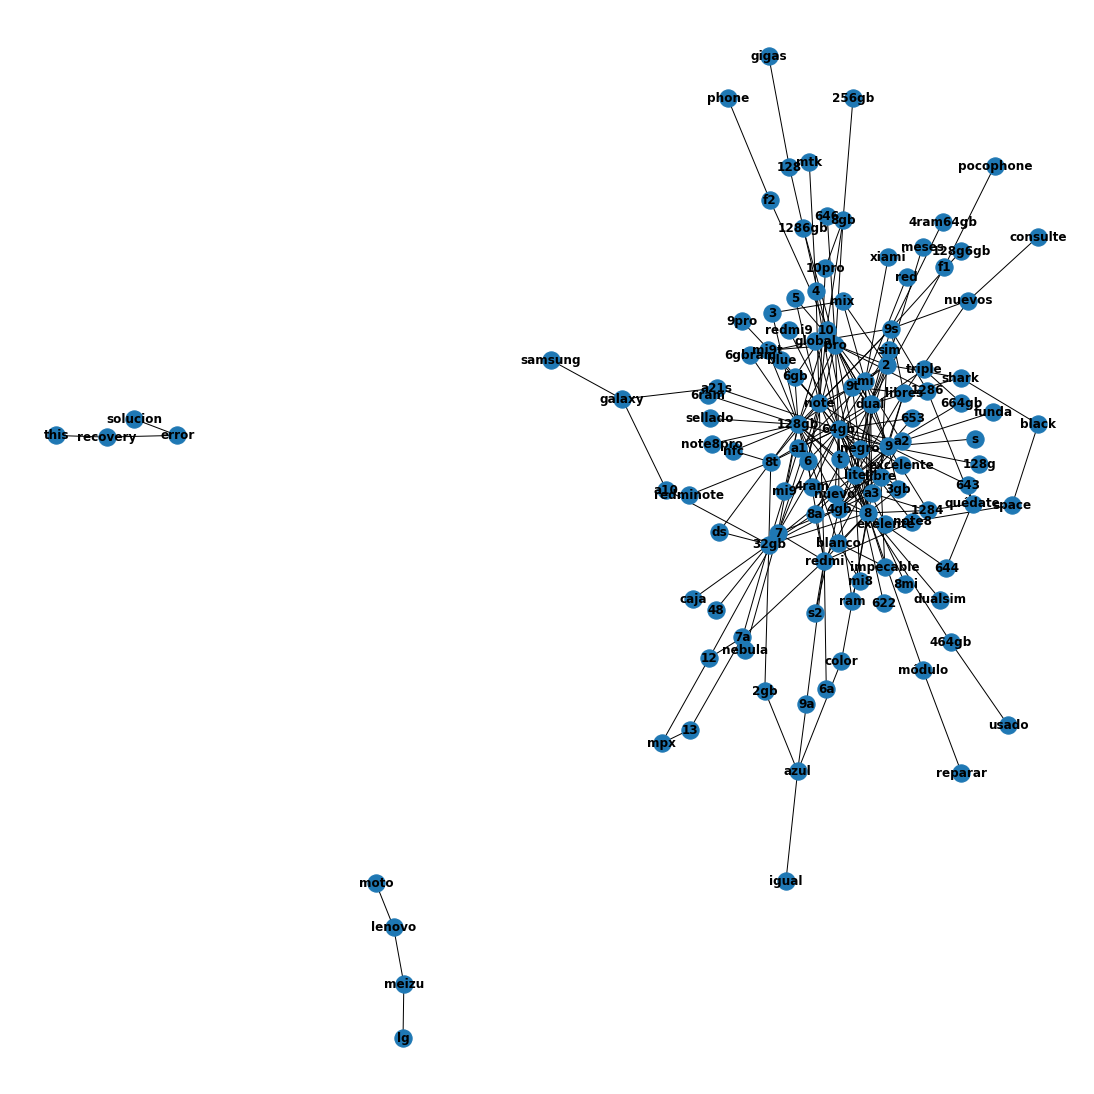

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
nx.draw(G, with_labels=True, font_weight='bold')
plt.plot()
plt.show()

In [2]:
['mi 9t 64gb triple camara 48mpx _s', 'mi a2 lite', 'mi a3 modulo roto', 'mi mix 2 libre garantia', 'mi mix 3 128gb 6gb peefecto libre garanti', 'mi note 10 128gb 6gb ram dual sim nfc tienda hyt', 'mi note 10 128gb global _s', 'mi note 10 128gb white 18 cuotas garantia factura', 'mi note 10 lite 128gb 6gb ram cam 64mpx', 'mi note 10 lite 64 dual sim color', 'mi note 10 lite 647 128gb 6gb ram 64mp 730g _s', 'mi note 10 lite 64gb 6gb ram dual sim nfc tienda hyt', 'note 7 128gb 4gb ram azul negro cam 48 mp vglobal', 'redmi 6 64gb 4gb rom excelente case', 'redmi 7a 32gb 2gb ram 4g lte bateria 4000 mah grti', 'redmi 7a 32gb ds', 'redmi 9 4gb 64gb dual verde oceano burzaco', 'redmi 9 4gb ram 64gb rom', 'redmi 9 64gb 4ram dual sim púrpura edicion junio 2020', 'redmi 9 653 64gb 4gb ram 13mp _s', 'redmi 9a azul 2gb ram 32gb', 'redmi 9a azul 2gb ram 32gb cuotas', 'redmi 9a azul 2gb ram 32gb daul sim garantia envios', 'redmi note 7 128gb 4gb ram 48 mp', 'redmi note 8 4gb 64gb 63 4000mah cuadruple camara', 'redmi note 8 4gb ram 64gb lte 4g funda', 'redmi note 8 64gb 4 ram nuevos oferta', 'redmi note 8 64gb 4gb ram glass vidrio camara', 'redmi note 8 64gb liberados version global', 'redmi note 8 dual 128gb 4gb ram _s', 'redmi note 8 pro 128gb 4500mah 2019 64mpx vidrio', 'redmi note 8 pro dual sim 128gb blanco nácar 6gb ra', 'redmi note 8t dual 32gb 3gb ram _s', 'redmi note 8t dual sim 128gb azul estelar 4gb ram', 'redmi note 8t dual sim nfc 4 cámaras 4gb ram 64gb', 'redmi note 9 128g', 'redmi note 9 3gb 64gb dual gris burzaco', 'redmi note 9 653 128gb 4gb ram octa core _s', 'redmi note 9 dual sim 128gb 4gb ram cuotas', 'redmi note 9 dual sim 128gb color', 'redmi note 9 dual sim 128gb midnight grey 4gb ram', 'redmi note 9 pro 128gb 6gb ram nfc tienda hyt', 'redmi note 9 pro 6gb 64gb dual verde burzaco', 'redmi note 9 pro dual sim 64gb gris interestelar 6 g', 'redmi note 9s dual 128gb cuotas lanzamiento 2020', 'redmi note8 64gb 4gb ram liberado envío domicilio', 'redmi9']


['mi 9t 64gb triple camara 48mpx _s',
 'mi a2 lite',
 'mi a3 modulo roto',
 'mi mix 2 libre garantia',
 'mi mix 3 128gb 6gb peefecto libre garanti',
 'mi note 10 128gb 6gb ram dual sim nfc tienda hyt',
 'mi note 10 128gb global _s',
 'mi note 10 128gb white 18 cuotas garantia factura',
 'mi note 10 lite 128gb 6gb ram cam 64mpx',
 'mi note 10 lite 64 dual sim color',
 'mi note 10 lite 647 128gb 6gb ram 64mp 730g _s',
 'mi note 10 lite 64gb 6gb ram dual sim nfc tienda hyt',
 'note 7 128gb 4gb ram azul negro cam 48 mp vglobal',
 'redmi 6 64gb 4gb rom excelente case',
 'redmi 7a 32gb 2gb ram 4g lte bateria 4000 mah grti',
 'redmi 7a 32gb ds',
 'redmi 9 4gb 64gb dual verde oceano burzaco',
 'redmi 9 4gb ram 64gb rom',
 'redmi 9 64gb 4ram dual sim púrpura edicion junio 2020',
 'redmi 9 653 64gb 4gb ram 13mp _s',
 'redmi 9a azul 2gb ram 32gb',
 'redmi 9a azul 2gb ram 32gb cuotas',
 'redmi 9a azul 2gb ram 32gb daul sim garantia envios',
 'redmi note 7 128gb 4gb ram 48 mp',
 'redmi note 8 4gb 6

In [33]:
documents = ['mi 9 lavender violet mejor s10 gama alta 6gb ram', 
'mi 9t 64gb triple camara 48mpx _s',
'mi 9t pro 64gb triple camara 48mpx _s',
'mi 9tpro 64gb triple camara 48mpx _s',
'mi 9t pro 64gb negro modulo roto prepuesto', 
'mi a2 lite', 
'mi a3 dual sim 64gb 4gb ram blanco azul', 
'mi mix 2 libre garantia', 
'mi mix 3 128gb 6gb peefecto libre garanti', 
'mi note 10 1286gb ram cam 108mpx bat5260', 
'mi note 10 128gb 6 ram 108mp penta cámara 647 lte', 
'mi note 10 128gb 6gb ram dual sim nfc tienda hyt', 
'mi note 10 128gb global _s', 
'mi note 10 128gb white 18 cuotas garantia factura', 
'mi note 10 lite 128gb 6gb ram cam 64mpx', 
'mi note 10 lite 64 dual sim color', 
'mi note 10 lite 647 128gb 6gb ram 64mp 730g _s', 
'mi note 10 lite 64gb 6gb ram dual sim nfc tienda hyt', 
'mi9t 64gb 6ram glaciar blue', 
'note 10 lite 128gb 6gb ram sellado orig gtia', 
'note 10 lite 64gb 6gb ram sellado orig gtia', 
'note 7 128gb 4gb ram azul negro cam 48 mp vglobal', 
'note 8 1284 quédate casa envíos domicilio', 
'note 8 644 quédate casa envíos domicilio', 
'note 8 64gb dual sim libre', 
'note 8 pro 1286 quédate casa envíos domicilio', 
'note 8 pro 6gb 128gb cam 2064mpx funda', 
'note 8 pro 6gb 64gb cam 2064mpx funda', 
'note 8t 644 quédate casa envíos domicilio', 
'note 9 1284 quédate casa envíos domicilio', 
'note 9 128gb sellado accesorios libre fab', 
'note 9 643 quédate casa envíos domicilio', 
'note 9 pro', 
'redmi 6a', 
'redmi 7 32gb', 
'redmi 7a 32gb', 
'redmi 7a 32gb 2gb ram 4g lte bateria 4000 mah grti', 
'redmi 7a 32gb ds', 
'redmi 8 64gb 4gb mercadopago local', 
'redmi 8 libres nuevos global 64gb funda gtia', 
'redmi 8a 322 quédate casa envíos domicilio', 
'redmi 8a 32gb 5000 mah dual sim 2gb ram libres new', 
'redmi 8a nuevo libre', 
'redmi 9 4 ram 64 rom modelo nuevo 2020', 
'redmi 9 4 ram 64 rom nfc', 
'redmi 9 4gb 64gb dual verde oceano burzaco', 
'redmi 9 4gb ram 64gb rom', 
'redmi 9 644 quedate casa envios domicilio', 
'redmi 9 64gb 4ram dual sim gris edicion junio 2020', 
'redmi 9 64gb 4ram dual sim púrpura edicion junio 2020', 
'redmi 9 653 64gb 4gb ram 13mp _s', 
'redmi 9a azul 2gb ram 32gb', 
'redmi 9a azul 2gb ram 32gb cuotas', 
'redmi 9a azul 2gb ram 32gb daul sim garantia envios', 
'redmi 9a gris carbon 2gb ram 32gb', 
'redmi note 7 128gb 4gb ram 48 mp', 
'redmi note 7 4gb 128gb neptune', 
'redmi note 8', 
'redmi note 8 4gb 64gb 63 4000mah cuadruple camara', 
'redmi note 8 4gb ram 64gb lte 4g funda', 
'redmi note 8 64gb 4 ram nuevos oferta', 
'redmi note 8 64gb 4gb ram glass vidrio camara', 
'redmi note 8 64gb liberados version global', 
'redmi note 8 64gb liberados version global cuotas', 
'redmi note 8 dual 128gb 4gb ram _s', 
'redmi note 8 dual sim 64gb azul neptuno 4gb ram', 
'redmi note 8 dual sim 64gb negro space 4gb ram', 
'redmi note 8 libres 464gb 48mpx huella garantía', 
'redmi note 8 pro 128gb 4500mah 2019 64mpx vidrio', 
'redmi note 8 pro dual sim 128gb blanco nácar 6gb ra', 
'redmi note 8t dual 32gb 3gb ram _s', 
'redmi note 8t dual sim 128gb azul estelar 4gb ram', 
'redmi note 8t dual sim nfc 4 cámaras 4gb ram 64gb', 
'redmi note 9 128g', 
'redmi note 9 128g4gb camcuadruple octa core', 
'redmi note 9 3gb 64gb dual gris burzaco', 
'redmi note 9 4', 
'redmi note 9 64gb 3gb ram dual sim nfc', 
'redmi note 9 64gb 3ram 48mpx bat5020 4 cámaras gtia', 
'redmi note 9 64gb nuevo caja sellada green forest', 
'redmi note 9 653 128gb 4gb ram octa core _s', 
'redmi note 9 dual sim 128gb 4gb ram cuotas', 
'redmi note 9 dual sim 128gb color', 
'redmi note 9 dual sim 128gb midnight grey 4gb ram', 
'redmi note 9 dual sim 64gb gris medianoche 3gb ram', 
'redmi note 9 pro 646gb 5 cam 64mpx 5020mahp nfc gtia', 
'redmi note 9 pro 6gb 128gb 5020 mah funda', 
'redmi note 9 pro 6gb 64gb dual verde burzaco', 
'redmi note 9 pro dual sim 64gb gris interestelar 6 g', 
'redmi note 9 pro dual sim 6gb 128gb gris interestelar', 
'redmi note 9s 4gb 64gb nuevo caja', 
'redmi note 9s dual 128gb cuotas lanzamiento 2020', 
'redmi note 9s global 4gb ram 64gb funda grtia locale', 
'redmi note 9s global 6gb ram 128gb funda grtia local', 
'redmi9']

In [36]:
from benedict import benedict
import json
tree = benedict()
for document in documents:
    print(document)
    path = ""
    for node in document.split():
        path += f".{node}"
        tree[path+".counter"]=tree.get(path+".counter",0)+1
json.dumps(tree)

mi 9 lavender violet mejor s10 gama alta 6gb ram
mi 9t 64gb triple camara 48mpx _s
mi 9t pro 64gb triple camara 48mpx _s
mi 9tpro 64gb triple camara 48mpx _s
mi 9t pro 64gb negro modulo roto prepuesto
mi a2 lite
mi a3 dual sim 64gb 4gb ram blanco azul
mi mix 2 libre garantia
mi mix 3 128gb 6gb peefecto libre garanti
mi note 10 1286gb ram cam 108mpx bat5260
mi note 10 128gb 6 ram 108mp penta cámara 647 lte
mi note 10 128gb 6gb ram dual sim nfc tienda hyt
mi note 10 128gb global _s
mi note 10 128gb white 18 cuotas garantia factura
mi note 10 lite 128gb 6gb ram cam 64mpx
mi note 10 lite 64 dual sim color
mi note 10 lite 647 128gb 6gb ram 64mp 730g _s
mi note 10 lite 64gb 6gb ram dual sim nfc tienda hyt
mi9t 64gb 6ram glaciar blue
note 10 lite 128gb 6gb ram sellado orig gtia
note 10 lite 64gb 6gb ram sellado orig gtia
note 7 128gb 4gb ram azul negro cam 48 mp vglobal
note 8 1284 quédate casa envíos domicilio
note 8 644 quédate casa envíos domicilio
note 8 64gb dual sim libre
note 8 pro 128

'{"": {"mi": {"counter": 18, "9": {"counter": 1, "lavender": {"counter": 1, "violet": {"counter": 1, "mejor": {"counter": 1, "s10": {"counter": 1, "gama": {"counter": 1, "alta": {"counter": 1, "6gb": {"counter": 1, "ram": {"counter": 1}}}}}}}}}, "9t": {"counter": 3, "64gb": {"counter": 1, "triple": {"counter": 1, "camara": {"counter": 1, "48mpx": {"counter": 1, "_s": {"counter": 1}}}}}, "pro": {"counter": 2, "64gb": {"counter": 2, "triple": {"counter": 1, "camara": {"counter": 1, "48mpx": {"counter": 1, "_s": {"counter": 1}}}}, "negro": {"counter": 1, "modulo": {"counter": 1, "roto": {"counter": 1, "prepuesto": {"counter": 1}}}}}}}, "9tpro": {"counter": 1, "64gb": {"counter": 1, "triple": {"counter": 1, "camara": {"counter": 1, "48mpx": {"counter": 1, "_s": {"counter": 1}}}}}}, "a2": {"counter": 1, "lite": {"counter": 1}}, "a3": {"counter": 1, "dual": {"counter": 1, "sim": {"counter": 1, "64gb": {"counter": 1, "4gb": {"counter": 1, "ram": {"counter": 1, "blanco": {"counter": 1, "azul":

In [22]:
from benedict import benedict
d = benedict()

# set values by keys list
d['','mi', '9t'] = {}
d['mi', '9t',"counter"] = d.get("mi.9h.counter",0)+1
d['profile', 'lastname'] = 'Caccamo'
print(d) # -> { 'profile':{ 'firstname':'Fabio', 'lastname':'Caccamo' } }
print(d['profile']) # -> { 'firstname':'Fabio', 'lastname':'Caccamo' }

# check if keypath exists in dict
print(['profile', 'lastname'] in d) # -> True

# delete value by keys list
del d['profile', 'lastname']
print(d['profile']) # -> { 'firstname':'Fabio' }
print(d)

{'': {'mi': {'9t': {}}}, 'mi': {'9t': {'counter': 1}}, 'profile': {'lastname': 'Caccamo'}}
{'lastname': 'Caccamo'}
True
{}
{'': {'mi': {'9t': {}}}, 'mi': {'9t': {'counter': 1}}, 'profile': {}}


In [83]:
tree = {}

def count_products(tree, n_products=0):
    # se detiene cuando el counter se hace 1, en ese caso agrega 1 al producto
    # print(f"counter: {tree.get('counter')}")
    if tree.get("counter") == 1:
        return 1
    for key, sub_tree in tree.items():
        if key != "counter":
            # print(f"key: {key}")
            n_products += count_products(sub_tree)
            # print(n_products)
    return n_products


count_p = count_products(tree)
print(count_p)


0


# Checking the values to include into the filtering
The idea of this proposal is to filter by the values that must appear and not the contrary

In [81]:
import re
articles_titles = []
GET_GB_PATTERN = re.compile(r'([0-9]*gb)')
set(sorted([GET_GB_PATTERN.search(article).group(1) for article in articles_titles if GET_GB_PATTERN.search(article)]))
#xiaomi_words = set([word for model in xiaomi_models for word in REMOVE_PUNCTUATION_PATTERN.sub('', model).lower().split()])

{'1286gb',
 '128gb',
 '16gb',
 '256gb',
 '2gb',
 '32gb',
 '332gb',
 '3gb',
 '464gb',
 '4gb',
 '64gb',
 '664gb',
 '6gb',
 '8gb'}

In [82]:
xiaomi_models = []
REMOVE_PUNCTUATION_PATTERN = re.compile(r'[^\w\s]')
xiaomi_words = set([word for model in xiaomi_models for word in REMOVE_PUNCTUATION_PATTERN.sub('', model).lower().split()])
